# Exploring SNSF Public Data

## Foreword

The [Swiss National Science Foundation](http://www.snf.ch/en/Pages/default.aspx) (SNSF) is the leading public science funding agency in Switzerland.  In _GrantExport_, the SNSF provides detailed information about approved grants.  In _PersonExport_, it also provides details about people associated to each grant.  Other tables provide further data about publications, outputs, and collaborations reported by applicants.  You can find the datasets and their documentation in [p3.snf.ch](http://p3.snf.ch/Pages/DataAndDocumentation.aspx).

Prior to exploring the data, I performed some cleaning operations on _GrantExport_ and on _PersonExport_.

In this notebook, we will look at the data in _GrantExport_ and _PersonExport_ and try to get some insights on how funding differs for men and women.

In [1]:
import os
import sqlite3

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(12, 8)})

DATA_FOLDER = '../data'

In [2]:
conn = sqlite3.connect(os.path.join(DATA_FOLDER, 'p3.db'),
                       detect_types=sqlite3.PARSE_DECLTYPES)
grants = pd.read_sql_query('SELECT * FROM project;', conn)
people = pd.read_sql_query('SELECT * FROM person;', conn)
hr = pd.read_sql_query('SELECT * FROM hr;', conn)


## Overview

Quick inspection of each dataset, one-by-one.

In [3]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111690 entries, 0 to 111689
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          111690 non-null  int64 
 1   gender      111690 non-null  object
 2   first_name  111683 non-null  object
 3   last_name   111690 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.4+ MB


In [4]:
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256654 entries, 0 to 256653
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          256654 non-null  int64 
 1   project_id  256654 non-null  int64 
 2   person_id   256654 non-null  int64 
 3   role        256654 non-null  object
dtypes: int64(3), object(1)
memory usage: 7.8+ MB


In [5]:
grants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74805 entries, 0 to 74804
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  74805 non-null  int64         
 1   programme           74765 non-null  object        
 2   funding_instrument  74805 non-null  object        
 3   domain              74301 non-null  object        
 4   topic               71018 non-null  object        
 5   discipline_name     74805 non-null  object        
 6   start_date          74805 non-null  datetime64[ns]
 7   end_date            74805 non-null  datetime64[ns]
 8   approved_amount     61607 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 5.1+ MB


In [6]:
# time range
grants.start_date.min(), grants.end_date.max()

(Timestamp('1975-01-06 00:00:00'), Timestamp('2025-10-31 00:00:00'))

_GrantExport_ contains ca. 74.5k grants, spanning across 50 years, from 1975 to 2025.

### Temporal trends

#### Approved grants

In [7]:
grants['year'] = grants['start_date'].dt.year

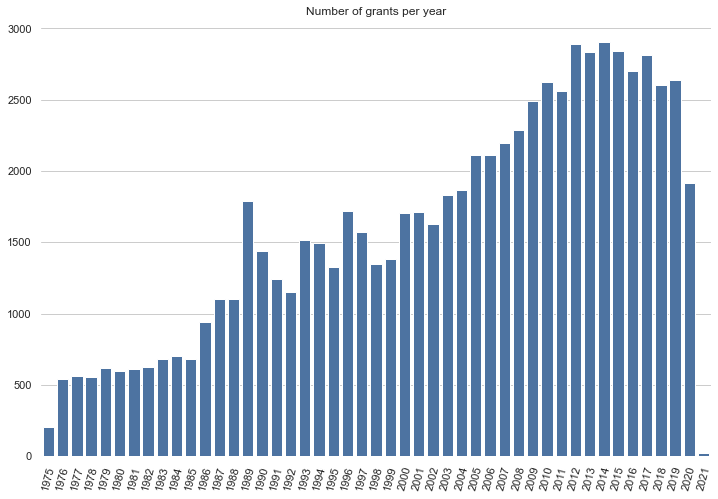

In [8]:
sns.set_style("whitegrid")
plt.box(on=None) 
g = sns.countplot(x='year', data=grants, color='#3f72af')
g.set_xlabel('')
g.set_ylabel('')
g.set_title('Number of grants per year')
g.set_xticklabels(g.get_xticklabels(), rotation=75, horizontalalignment='center')
g;

The number of grants nearly duplicated in 20 years.

#### Funding commitments

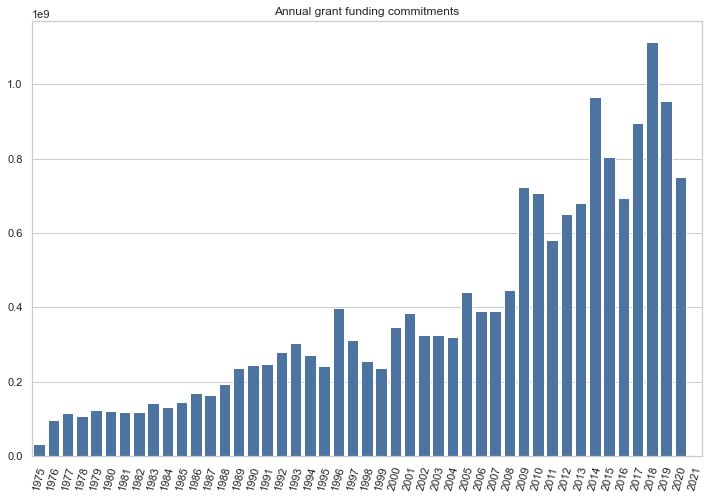

In [9]:
annual_funding = grants.groupby(['year'])['approved_amount'].sum().reset_index()
g = sns.barplot(x='year', y='approved_amount', data=annual_funding, color='#3f72af')
g.set_xlabel('')
g.set_ylabel('')    
g.set_title('Annual grant funding commitments')
g.set_xticklabels(g.get_xticklabels(), rotation=75, horizontalalignment='center', fontweight='light')
g;

In [10]:
annual_counts = grants.groupby(['year']).size().reset_index().rename(columns={0:'count'})
annual_stats = annual_counts.merge(annual_funding, on='year')
annual_stats = annual_stats.query('year < 2020')

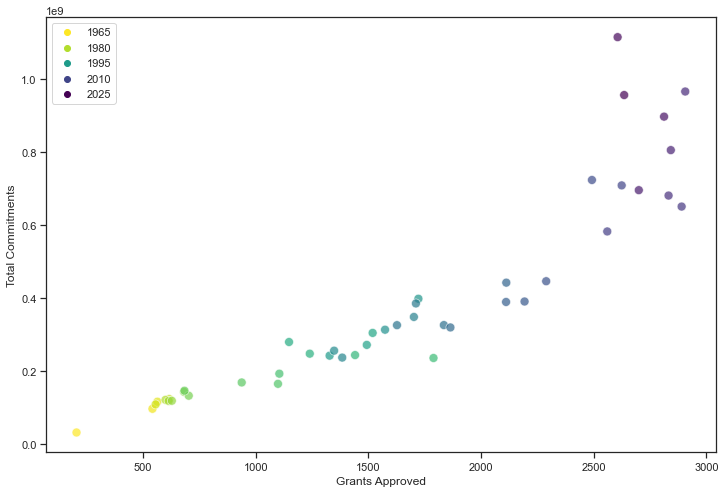

In [11]:
sns.set_style("ticks")
g = sns.scatterplot(x="count", y="approved_amount", hue=annual_stats.year.tolist(), palette='viridis_r', alpha=.7, s = 80, data=annual_stats)
g.set_xlabel('Grants Approved')
g.set_ylabel('Total Commitments')  
g;

A scatterplot between the annual funding commitments and the grants approved shows a higher spread in more recent years.

## Role and gender

In this section, we consider both the role and the gender of the person involved in the project.  The totals are the following:

In [12]:
(hr
 .merge(people[['id', 'gender']], left_on='person_id', right_on='id')
 .groupby(['gender', 'role']).size())

gender  role                 
female  applicant                 6557
        contact_person             217
        employee                 50869
        partner                   1572
        practice_partner           253
        responsible_applicant    15718
male    applicant                40139
        contact_person             816
        employee                 77181
        partner                   4593
        practice_partner           543
        responsible_applicant    58196
dtype: int64

In [13]:
workforce = (hr
   .merge(people[['id', 'gender']], left_on='person_id', right_on='id')
   .merge(grants, left_on='project_id', right_on='id'))

In [14]:
projects_with_employees = (workforce
 .query('role in ["responsible_applicant", "employee"]')
 .groupby(['project_id', 'role'])
 .size()
 .reset_index(name="n")
 .pivot_table(index="project_id", columns="role", values="n", fill_value=0)
 .query('responsible_applicant > 0')
 .query('employee > 0'))

In [15]:
# remove Careers and Science communication from grants
grant_selection = (workforce
   .merge(projects_with_employees, on="project_id")
   .query('role in ["responsible_applicant", "employee"]')
   .query('programme in ["Infrastructure", "Programmes", "Project funding"]')[['project_id']]
   .drop_duplicates()
   .reset_index(drop=True)
)

In [16]:
grants = grants.merge(grant_selection, left_on='id', right_on='project_id')

### Project leaders

A project leader is a scientist where `role == 'responsible_applicant'`.

In [17]:
# grants represented by their main applicants
pi = hr.query('role == "responsible_applicant"').merge(grants, left_on='project_id', right_on='id')
# adding gender from people table
pi = pi.merge(people[['id', 'gender']], left_on='person_id', right_on='id')

In [18]:
pi.head(3)

,id_x,project_id_x,person_id,role,id_y,programme,funding_instrument,domain,topic,discipline_name,start_date,end_date,approved_amount,year,project_id_y,id,gender
0,2,8532,3268,responsible_applicant,8532,Project funding,Project funding (Div. I-III),Biology and Medicine,Clinical Medicine,Clinical Cancer Research,1986-01-01,1988-12-31,211427.0,1986,8532,3268,male
1,7,163005,663520,responsible_applicant,163005,Project funding,Project funding (Div. I-III),"Mathematics, Natural- and Engineering Sciences",Physics,Condensed Matter Physics,2016-01-01,2019-09-30,608308.0,2016,163005,663520,male
2,8,188532,663520,responsible_applicant,188532,Project funding,Project funding (Div. I-III),"Mathematics, Natural- and Engineering Sciences",Physics,Condensed Matter Physics,2019-01-10,2023-09-30,942862.0,2019,188532,663520,male


In [19]:
annual_counts = pi.groupby(['year', 'gender']).size().reset_index(name="count")
annual_funding = pi.groupby(['year', 'gender'])['approved_amount'].sum().reset_index()
annual_stats = annual_counts.merge(annual_funding, on=['year', 'gender'])
annual_stats = annual_stats.query('year < 2020')

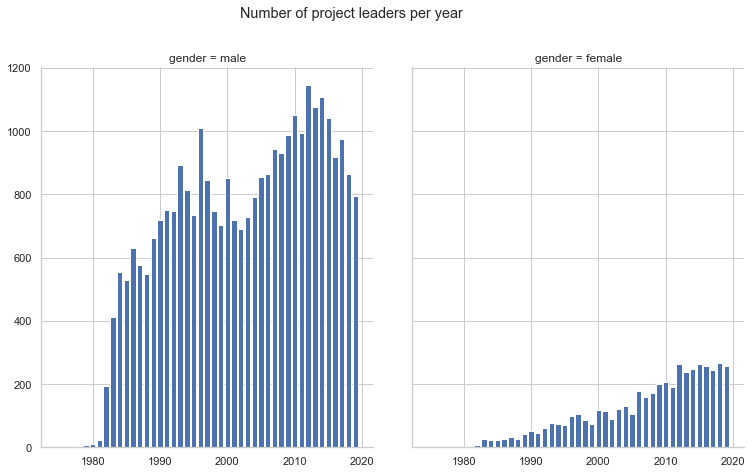

In [20]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_stats)
g.map(plt.bar, 'year', 'count')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Number of project leaders per year')
g;

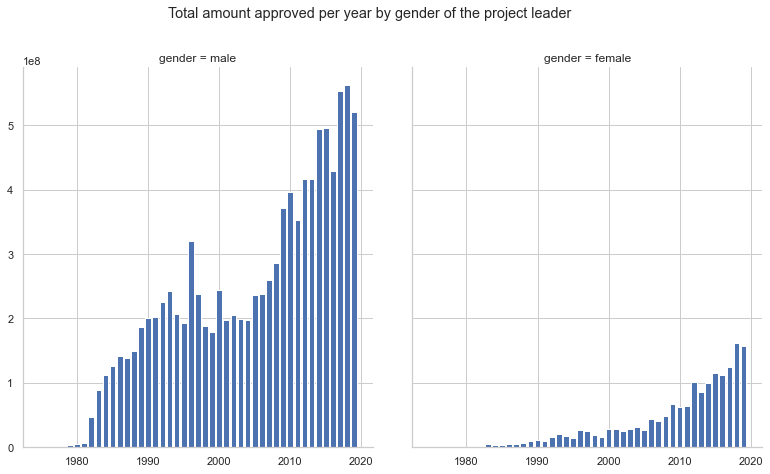

In [21]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_stats)
g.map(plt.bar, 'year', 'approved_amount')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Total amount approved per year by gender of the project leader')
g;

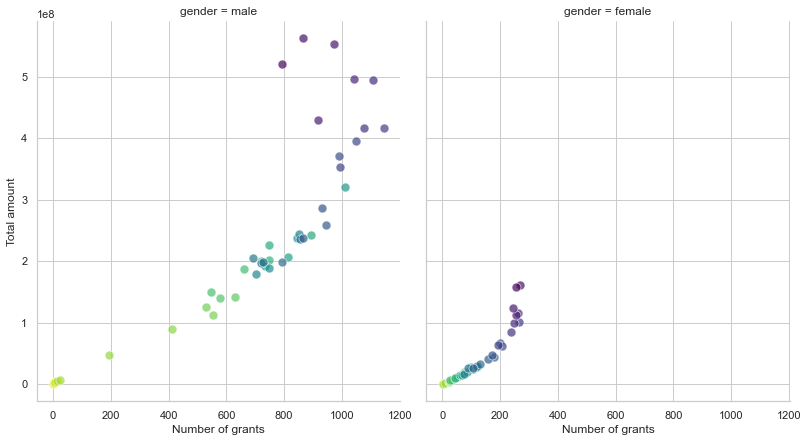

In [22]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', hue='year', palette='viridis_r', data=annual_stats)
g.map(sns.scatterplot, 'count', 'approved_amount', alpha=.7, s=80)
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels("Number of grants", "Total amount")
g;

### Project employees

In [23]:
workforce = hr.query('role == "employee"').merge(grants, left_on='project_id', right_on='id')
workforce = workforce.merge(people[['id', 'gender']], left_on='person_id', right_on='id')

In [24]:
annual_counts = workforce.groupby(['year', 'gender']).size().reset_index(name='count')
annual_counts = annual_counts.query('year < 2020')

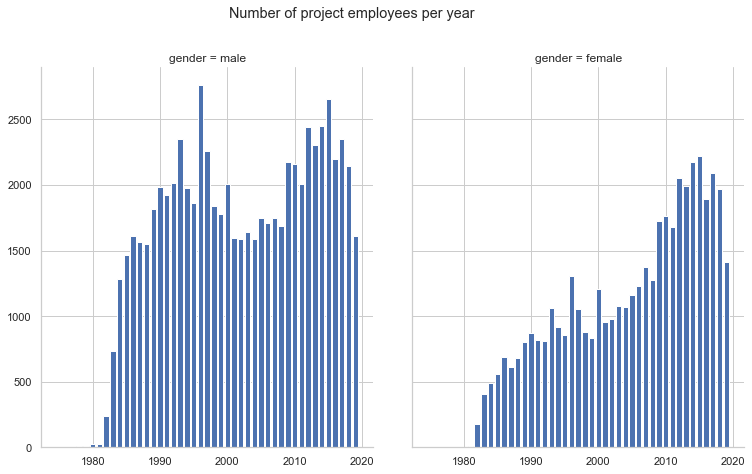

In [25]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_counts)
g.map(plt.bar, 'year', 'count')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Number of project employees per year')
g;